# Crime Analysis for Atlanta

## By: Anuja Jain, Kelly Tran, Qingyuan Jiang, Richard More

### Data from: http://www.atlantapd.org/i-want-to/crime-data-downloads
### NPU map from: https://www.atlantaga.gov/government/departments/city-planning/office-of-zoning-development/neighborhood-planning-unit-npu

# Importing modules

In [1]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.tree import export_graphviz
from IPython.display import SVG
import matplotlib.pyplot as plt
from keplergl import KeplerGl
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
import graphviz
import pickle

# Importing Atlanta data

In [2]:
atlpd_old = pd.io.parsers.read_csv("ATLPD_2009-2018.csv")
atlpd_new = pd.io.parsers.read_csv("ATLPD_09-23-2019.csv")

/home/ricsi/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


***

# Data cleaning and transformation

## Atlanta data renaming column with typo

In [3]:
atlpd_old["Shift Occurrence"] = atlpd_old["Shift Occurence"]
del atlpd_old["Shift Occurence"]

## Merging DataFrames

In [4]:
atlpd = pd.concat([atlpd_old, atlpd_new], sort = False, ignore_index = True)
atlpd.head(5)

,Report Number,Report Date,Occur Date,Occur Time,Possible Date,Possible Time,Beat,Apartment Office Prefix,Apartment Number,Location,Location Type,UCR Literal,UCR #,IBR Code,Neighborhood,NPU,Latitude,Longitude,Shift Occurrence
0,90010930,2009-01-01,2009-01-01,1145,2009-01-01,1148.0,408.0,NaN,NaN,2841 GREENBRIAR PKWY,8,LARCENY-NON VEHICLE,630,2303,Greenbriar,R,33.68845,-84.49328,Day Watch
1,90011083,2009-01-01,2009-01-01,1330,2009-01-01,1330.0,506.0,NaN,NaN,12 BROAD ST SW,9,LARCENY-NON VEHICLE,630,2303,Downtown,M,33.75320,-84.39201,Day Watch
2,90011208,2009-01-01,2009-01-01,1500,2009-01-01,1520.0,413.0,NaN,NaN,3500 MARTIN L KING JR DR SW,8,LARCENY-NON VEHICLE,630,2303,Adamsville,H,33.75735,-84.50282,Unknown
3,90011218,2009-01-01,2009-01-01,1450,2009-01-01,1510.0,204.0,NaN,NaN,3393 PEACHTREE RD NE,8,LARCENY-NON VEHICLE,630,2303,Lenox,B,33.84676,-84.36212,Evening Watch
4,90011289,2009-01-01,2009-01-01,1600,2009-01-01,1700.0,408.0,NaN,NaN,2841 GREENBRIAR PKWY SW,8,LARCENY-NON VEHICLE,630,2303,Greenbriar,R,33.68677,-84.49773,Unknown


## Atlanta data cleaning 2

In [5]:
atlpd.drop(["Report Date", "Possible Date", "Possible Time", "Apartment Office Prefix", "Apartment Number", "Location Type", "IBR Code"], axis = 1, inplace = True)
atlpd.dropna(subset = ["Neighborhood"], inplace = True)
atlpd.dropna(subset = ["NPU"], inplace = True)
atlpd["UCR Literal"] = atlpd["UCR Literal"].str.split("-", expand = True)[0]

## Converting Occur Date to Date type

In [6]:
atlpd["Occur Date"] = pd.to_datetime(atlpd["Occur Date"])

## Dropping lines where Report Time is wrong

In [7]:
index_wrong_time = atlpd[pd.to_numeric(atlpd["Occur Time"], errors = 'coerce').isnull()].index
atlpd.drop(index_wrong_time , inplace = True)

## Converting Occur Time to numeric type

In [8]:
atlpd["Occur Time"] = pd.to_numeric(atlpd["Occur Time"], errors = 'coerce')

## Converting times
* Where time is >= 2400 the date has to shift to the next day
* Where time is > 2400 the time is scaled down to the 0-2400 range

In [9]:
atlpd.loc[atlpd["Occur Time"] >= 2400, "Occur Date"] += pd.DateOffset(days = 1)
atlpd.loc[atlpd["Occur Time"] > 2400, "Occur Time"] -= 2400

## Convert some columns to Category type
* UCR Literal
* NPU
* Neighborhood

In [10]:
atlpd["UCR Literal"] = pd.Categorical(atlpd["UCR Literal"])
atlpd["NPU"] = pd.Categorical(atlpd["NPU"])
atlpd["Neighborhood"] = pd.Categorical(atlpd["Neighborhood"])

## Additional columns
* Year from Occur Date
* Month from Occur Date
* Day of Week from Occur Date
* Day of Week number
* Hour from Occur Time
* Lethalness: crimes in the following categories are considered lethal: AGG ASSAULT, LARCENY, HOMICIDE, MANSLAUGHTER
 * Lethalness from UCR Literal
 * Lethalness Num from UCR Literal
* UCR Code from UCR Literal
* Neighborhood Code from Neighborhood

In [11]:
atlpd["Year"] = atlpd["Occur Date"].dt.year
atlpd["Month"] = atlpd["Occur Date"].dt.month
atlpd["Day of Week"] = pd.Categorical(atlpd["Occur Date"].dt.day_name())
atlpd["DoW"] = atlpd["Occur Date"].dt.dayofweek
atlpd["Hour"] = atlpd["Occur Time"].round(-2)
atlpd["NPU Num"] = atlpd["NPU"].cat.codes
atlpd["Lethalness"] = pd.Categorical(np.where(atlpd["UCR Literal"].isin(["AGG ASSAULT", "LARCENY", "HOMICIDE", "MANSLAUGHTER"]),
                               "Lethal",
                               "Non-Lethal"))
atlpd["Lethalness Num"] = atlpd["Lethalness"].cat.codes
atlpd["UCR Code"] = atlpd["UCR Literal"].cat.codes
atlpd["Neighborhood Code"] = atlpd["Neighborhood"].cat.codes

## Additional time change
* After rounding the Occur Time we have 0 and 2400 both representing midnight -> change 2400 to 0

In [12]:
atlpd.loc[atlpd["Hour"] == 2400, "Hour"] = 0

## Dropping lines where Occur Date is earlier than 2009 or later than 08/31/2019

In [13]:
index_early_or_later = atlpd[(atlpd["Occur Date"].dt.year < 2009) | (atlpd["Occur Date"] >= pd.Timestamp("2019-09-01"))].index
atlpd.drop(index_early_or_later , inplace=True)

***

# Data Visulization and Exploratory Data Analytics

## Types of crime and numbers of reports

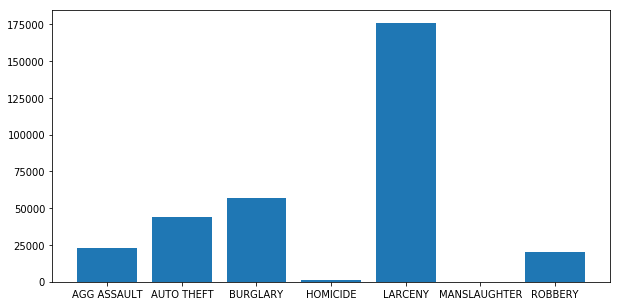

In [14]:
ucr_counts = atlpd.groupby("UCR Literal")["Report Number"].count()
plt.figure(figsize = (10, 5))
plt.bar(range(len(ucr_counts)), ucr_counts, align = "center")
plt.xticks(range(len(ucr_counts)), ucr_counts.index)
plt.show()

## Day of week and number of reports

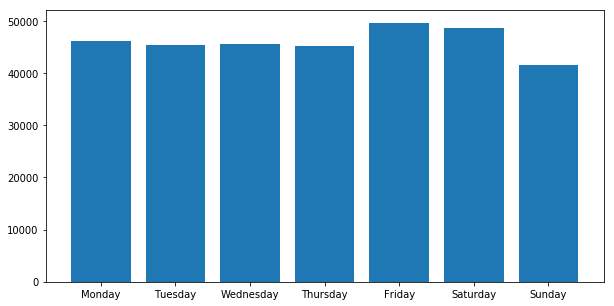

In [15]:
ucr_counts = atlpd.groupby("Day of Week")["Report Number"].count()
ucr_counts = ucr_counts.reindex(['Monday', 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.figure(figsize = (10, 5))
plt.bar(range(len(ucr_counts)), ucr_counts, align = "center")
plt.xticks(range(len(ucr_counts)), ucr_counts.index)
plt.show()

## Different crime types by day of week

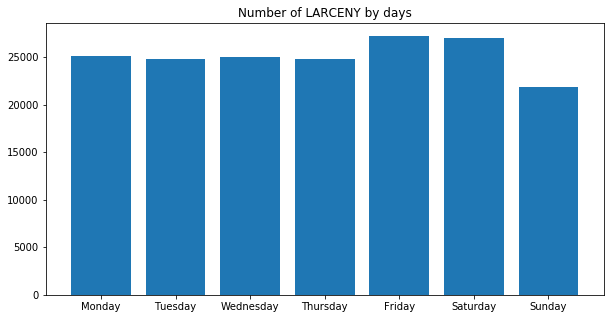

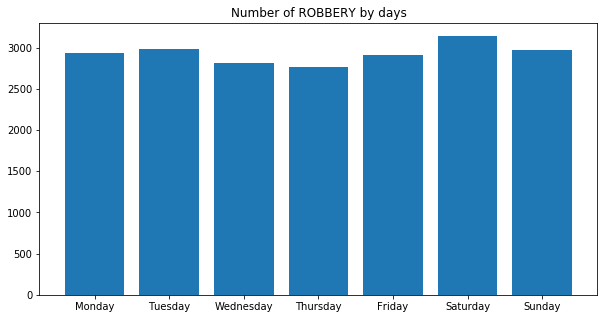

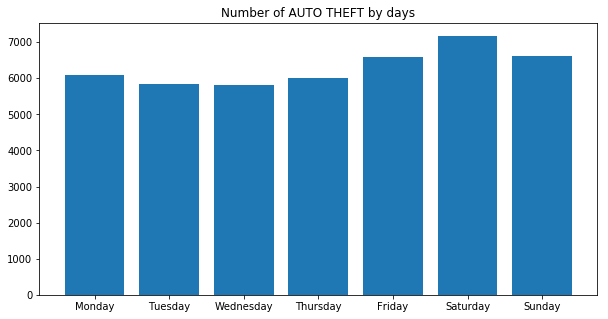

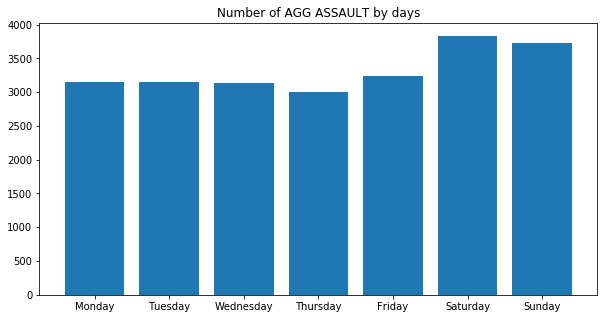

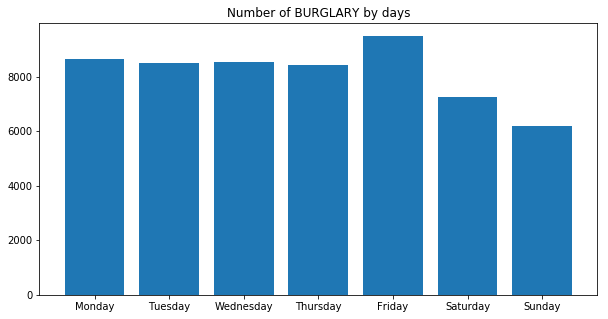

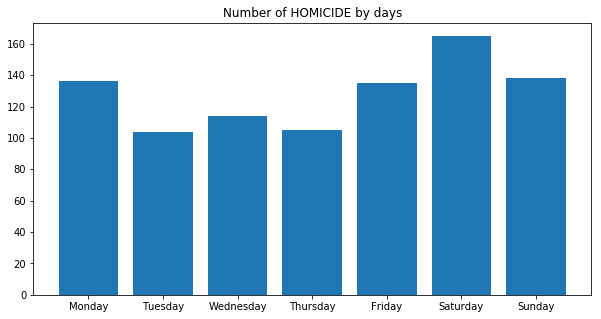

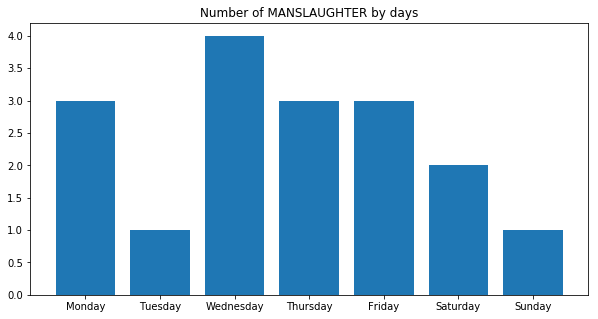

In [16]:
for ucr in atlpd["UCR Literal"].unique():
    ucr_counts = atlpd[(atlpd["UCR Literal"] == ucr)].groupby("Day of Week")["Report Number"].count()
    ucr_counts = ucr_counts.reindex(['Monday', 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    plt.figure(figsize = (10, 5))
    plt.bar(range(len(ucr_counts)), ucr_counts, align = "center")
    plt.xticks(range(len(ucr_counts)), ucr_counts.index)
    plt.title("Number of " + ucr + " by days")
    plt.show()

## Number of crimes per year

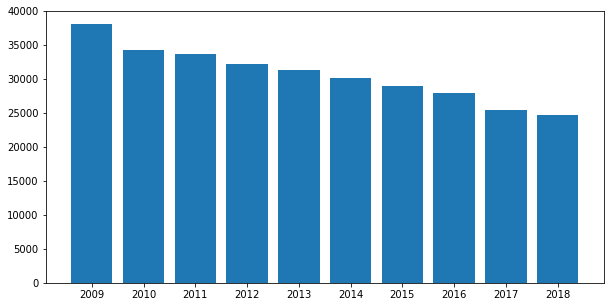

In [17]:
atlpd_prev = atlpd[(atlpd["Occur Date"].dt.year < 2019)]
year_counts = atlpd_prev.groupby("Year")["Report Number"].count()
plt.figure(figsize = (10, 5))
plt.bar(range(len(year_counts)), year_counts, align = "center")
plt.xticks(range(len(year_counts)), year_counts.index)
plt.show()

## Number of crimes by month

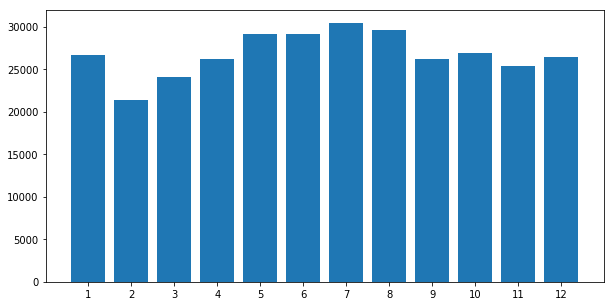

In [18]:
month_counts = atlpd.groupby("Month")["Report Number"].count()
plt.figure(figsize = (10, 5))
plt.bar(range(len(month_counts)), month_counts, align = "center")
plt.xticks(range(len(month_counts)), month_counts.index)
plt.show()

## Number of crimes by the hour

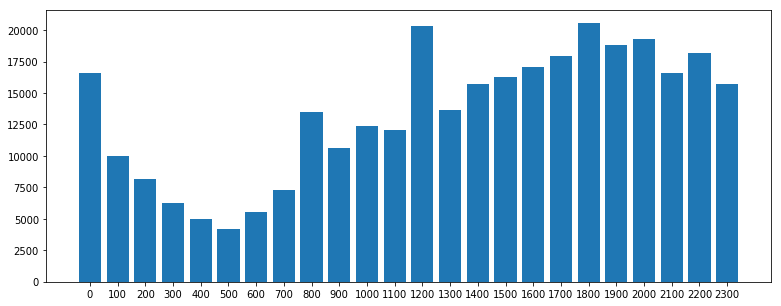

In [19]:
hour_counts = atlpd.groupby("Hour")["Report Number"].count()
plt.figure(figsize = (13, 5))
plt.bar(range(len(hour_counts)), hour_counts, align = "center")
plt.xticks(range(len(hour_counts)), hour_counts.index)
plt.show()

# Observations:
* The times when crimes are most likely to happen:
 * Midnight
 * Morning on the way to work
 * Lunchtime
 * Going home after work
 * When going out in the evening

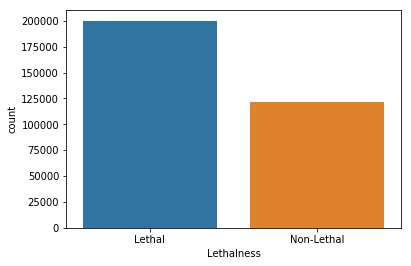

In [20]:
sns.countplot(x="Lethalness", data=atlpd)

## Lethalness by Area

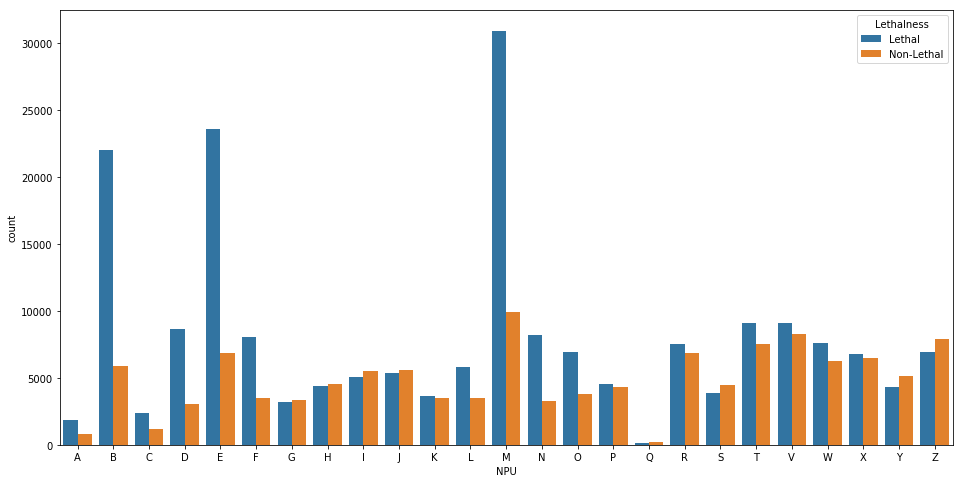

In [21]:
plt.figure(figsize = (16, 8))
sns.countplot(x = "NPU", hue = "Lethalness", data = atlpd)

### Lethalness of the crimes are higher in Area B, E and M. 
    Buckhead (B)
    Midtown (E)
    Downtown (M)

## Number of different crimes by time

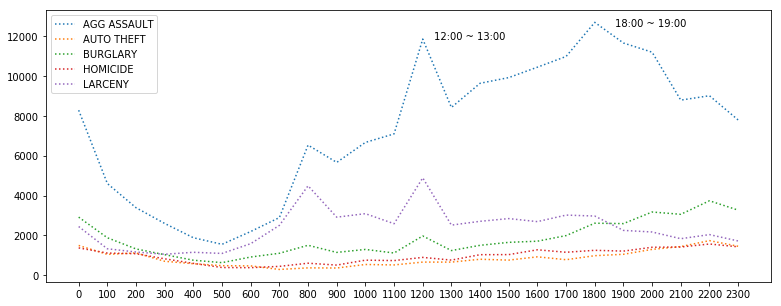

In [22]:
plt.figure(figsize = (13, 5))
for n, c in zip( atlpd['UCR Literal'].unique() , ['b','pink','y','g','r'] ):  
    x = atlpd.loc[ (atlpd["UCR Literal"] == n)].groupby(['Hour']).size().index
    y = atlpd.loc[ (atlpd["UCR Literal"] == n)].groupby(['Hour']).size()
    plt.plot(x, y, ':')
plt.annotate(xy = [1240,11861], s = '12:00 ~ 13:00')
plt.annotate(xy = [1870,12501], s = '18:00 ~ 19:00')
plt.legend(atlpd["UCR Literal"].cat.categories, loc = 2)
plt.xticks(x)
plt.show()

### Larceny and burglary happens mostly during the times when people are not at home

### Different type of Crime at different time
* Most Larceny happens between 12:00 ~ 21:00
* Most Burglay happens between 7:00 ~ 19:00
* Most Auto theft happens after 18:00


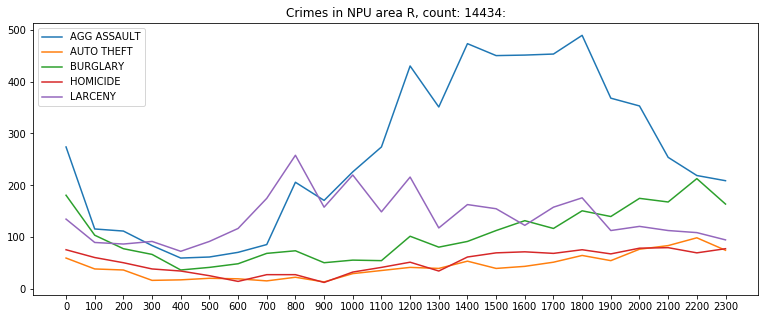

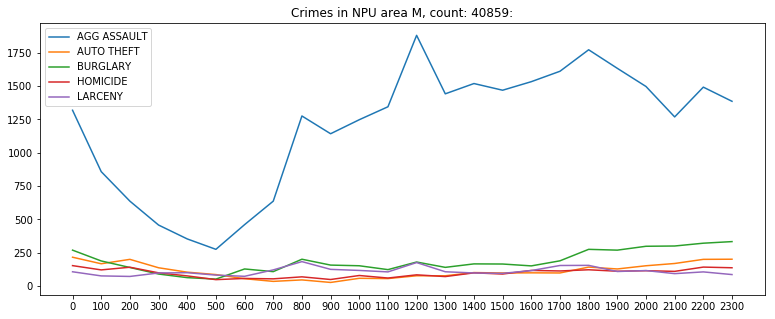

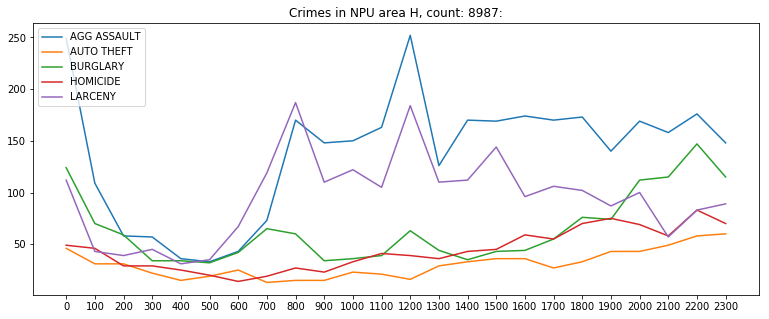

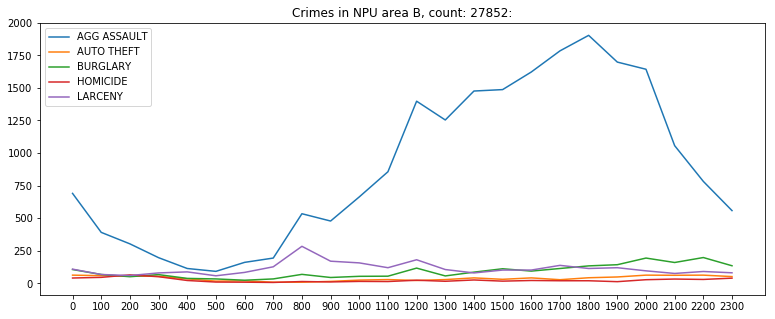

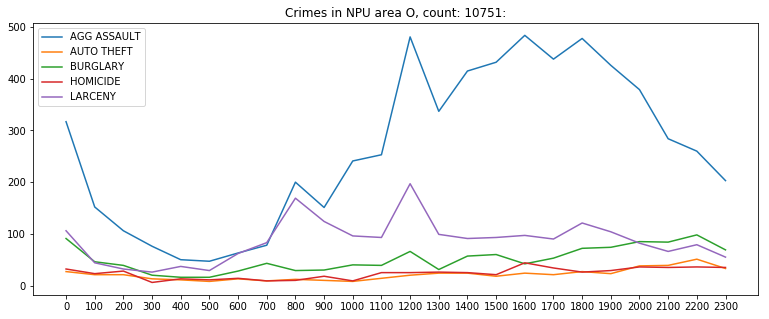

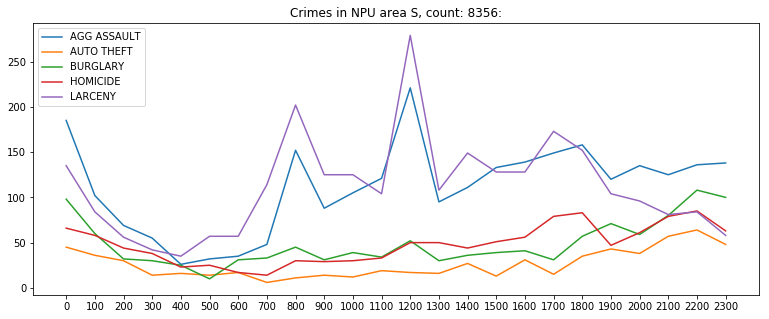

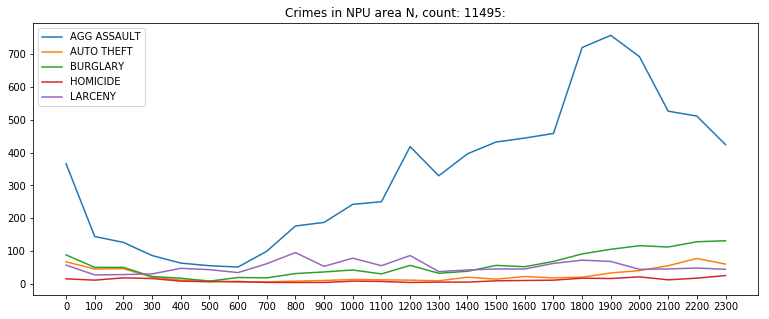

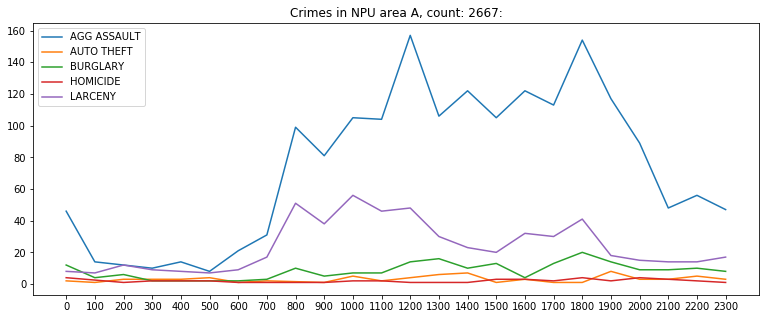

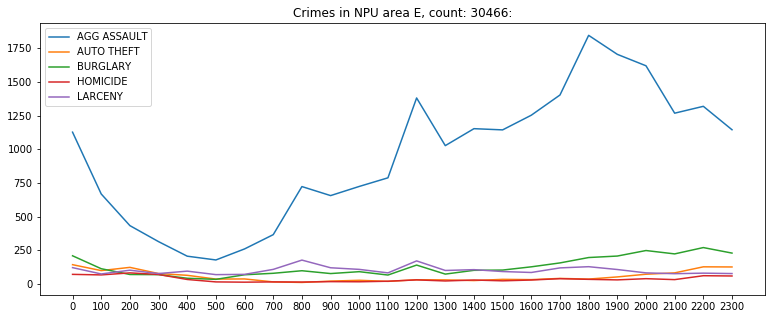

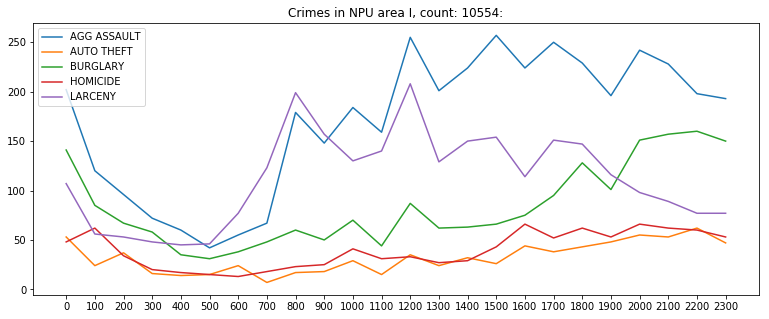

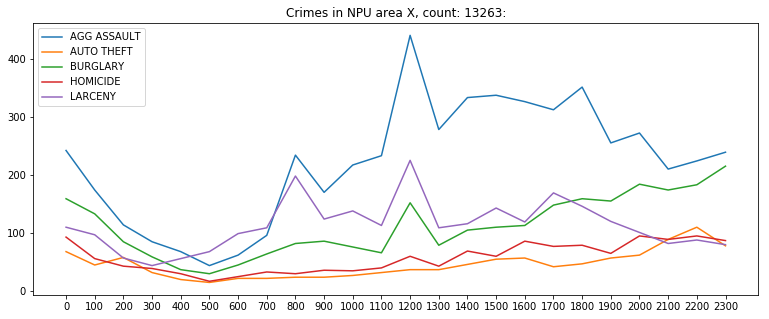

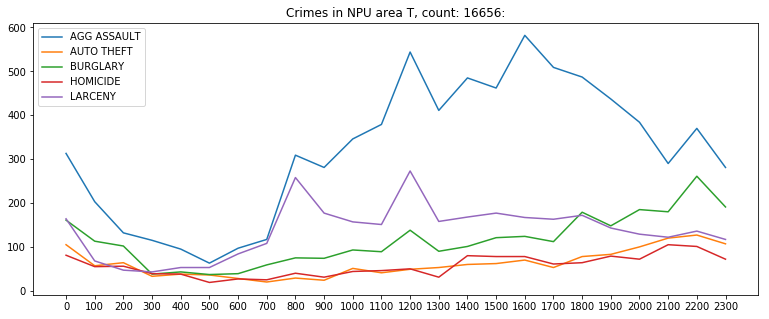

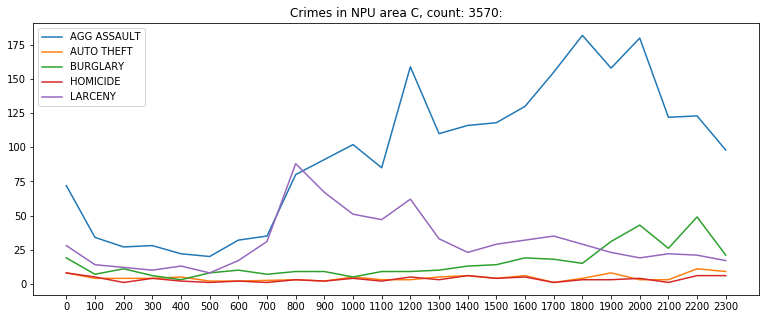

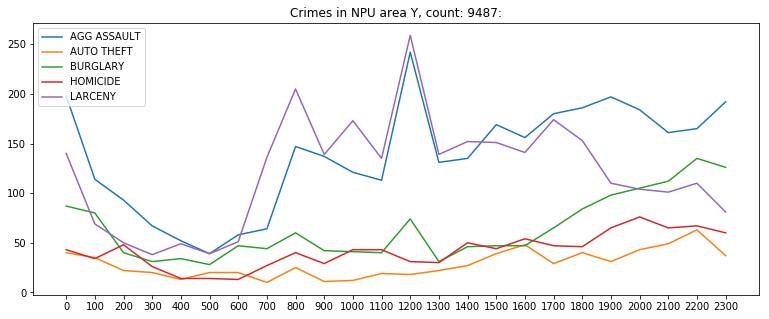

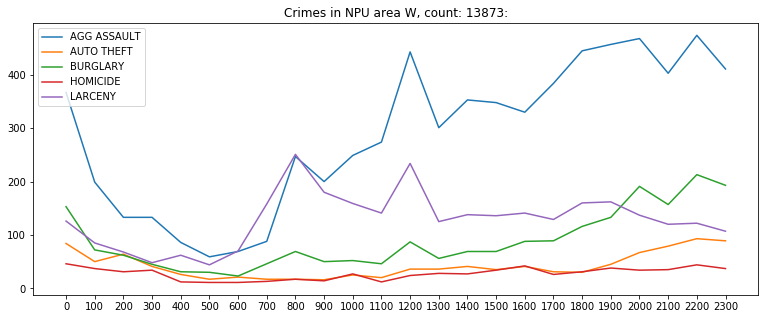

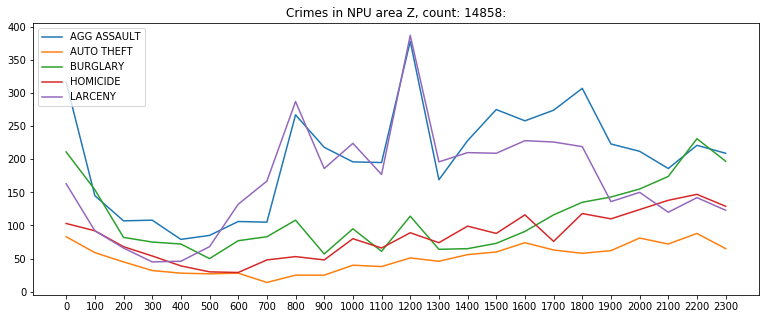

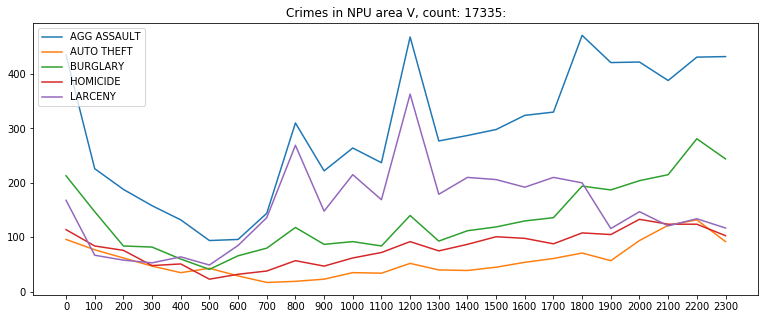

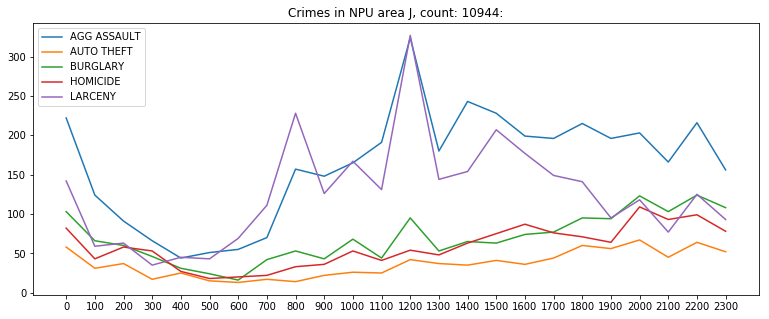

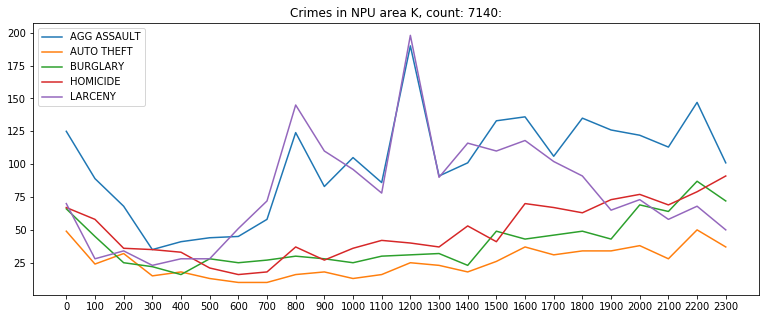

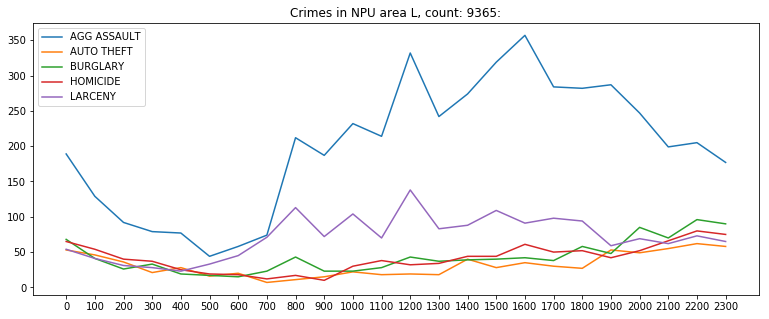

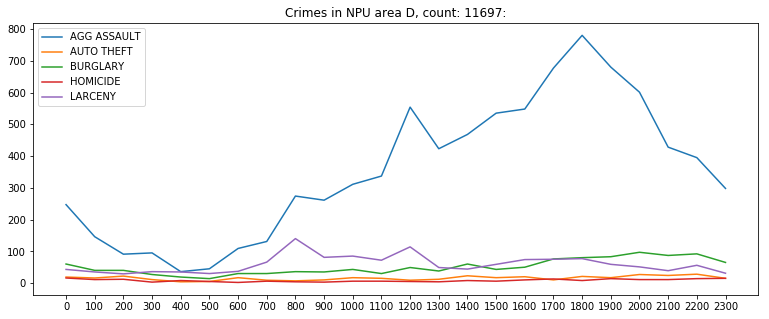

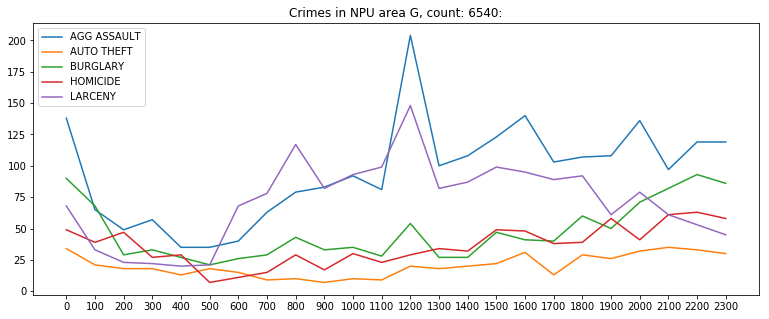

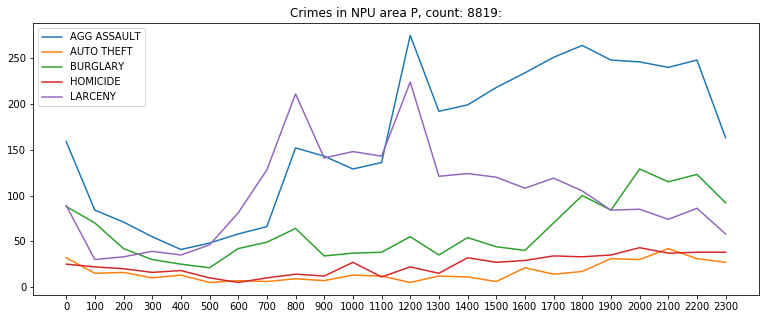

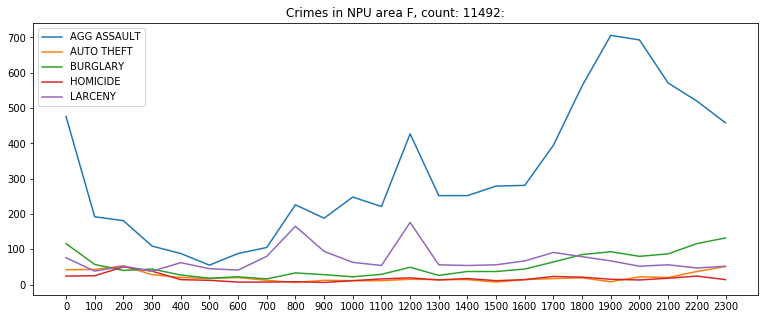

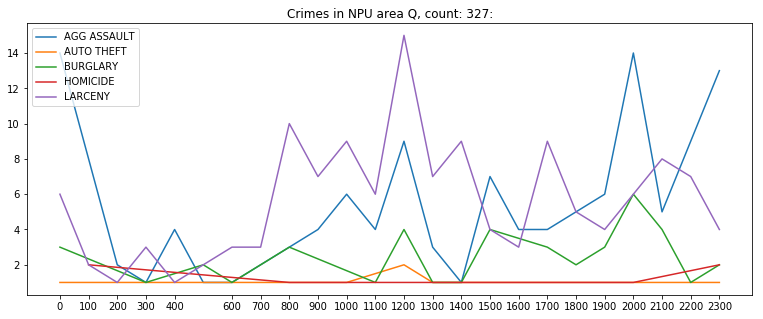

In [23]:
for i in atlpd["NPU"].unique():
    plt.figure(figsize = (13, 5))
    plt.title("Crimes in NPU area " + str(i) + ", count: " + str(len(atlpd[atlpd.NPU == i]['Longitude'])) + ":")
    for n, c in zip( atlpd['UCR Literal'].unique() , ['y','r','b','g','pink'] ):
        x = atlpd.loc[ (atlpd["UCR Literal"] == n ) & (atlpd['NPU'] == i)].groupby(['Hour']).size().index
        y = atlpd.loc[ (atlpd["UCR Literal"] == n ) & (atlpd['NPU'] == i)].groupby(['Hour']).size()
        plt.plot(x, y, '-')
    plt.legend(atlpd["UCR Literal"].cat.categories, loc = 2)
    plt.xticks(x)
    plt.show()

***

# Tables

## Crime counts by NPU

In [24]:
count_npu = atlpd.groupby("NPU")["Report Number"].count().rename("Crime Count", inplace = True)
npu_crimecount = pd.DataFrame(count_npu)
for ucr in atlpd["UCR Literal"].unique():
    npu_crimecount[ucr] = atlpd[(atlpd["UCR Literal"] == ucr)].groupby("NPU")["Report Number"].count()
npu_crimecount

,Crime Count,LARCENY,ROBBERY,AUTO THEFT,AGG ASSAULT,BURGLARY,HOMICIDE,MANSLAUGHTER
NPU,,,,,,,,
A,2667,1781,69,202,44,570,1,0
B,27852,21349,941,2213,618,2716,13,2
C,3570,2279,105,371,82,731,2,0
D,11697,8470,375,1224,201,1417,9,1
E,30466,22707,1360,3089,860,2427,22,1
F,11492,7574,513,1302,420,1661,22,0
G,6540,2281,491,1140,873,1715,39,1
H,8987,3314,739,1552,1057,2285,37,3
I,10554,4081,776,2022,953,2691,31,0


### Most dangerous place to live: 
* B,E,M (Crime coount>20,000)

### Best place to live:
* A,C (Crime count<4000)

## Crime proportions by NPU

In [25]:
npu_crimeprop = npu_crimecount.copy()
del npu_crimeprop["Crime Count"]
for ucr in atlpd["UCR Literal"].unique():
    npu_crimeprop[ucr] = npu_crimecount[ucr].div(npu_crimecount["Crime Count"], axis = 0)
npu_crimeprop = npu_crimeprop.style.format("{:.2%}")
npu_crimeprop

,LARCENY,ROBBERY,AUTO THEFT,AGG ASSAULT,BURGLARY,HOMICIDE,MANSLAUGHTER
NPU,,,,,,,
A,66.78%,2.59%,7.57%,1.65%,21.37%,0.04%,0.00%
B,76.65%,3.38%,7.95%,2.22%,9.75%,0.05%,0.01%
C,63.84%,2.94%,10.39%,2.30%,20.48%,0.06%,0.00%
D,72.41%,3.21%,10.46%,1.72%,12.11%,0.08%,0.01%
E,74.53%,4.46%,10.14%,2.82%,7.97%,0.07%,0.00%
F,65.91%,4.46%,11.33%,3.65%,14.45%,0.19%,0.00%
G,34.88%,7.51%,17.43%,13.35%,26.22%,0.60%,0.02%
H,36.88%,8.22%,17.27%,11.76%,25.43%,0.41%,0.03%
I,38.67%,7.35%,19.16%,9.03%,25.50%,0.29%,0.00%


***

# Map of Atlanta with frequencies of reports

In [26]:
with open("atl_map_conf.pickle") as f:
    atl_map_conf = pickle.load(f)
map_atl = KeplerGl(height = 800, config = atl_map_conf)
map_atl.add_data(data = atlpd, name = "ATLPD 2015-2019 Sept")
map_atl

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


S2VwbGVyR2woY29uZmlnPXt1J3ZlcnNpb24nOiB1J3YxJywgdSdjb25maWcnOiB7dSd2aXNTdGF0ZSc6IHt1J2xheWVycyc6IFt7dSd0eXBlJzogdSdoZXhhZ29uJywgdSd2aXN1YWxDaGFubmXigKY=


## Saving map configurations

In [27]:
with open("atl_map_conf.pickle", 'wb') as f:
    pickle.dump(map_atl.config, f)

***

# Predictive analysis

## K-NN

/home/ricsi/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Accuracy of K-NN classifier on training set: 0.64
Accuracy of K-NN classifier on test set: 0.62
Accuracy: 0.58
Precision: 0.39
Recall: 0.19
F1: 0.26


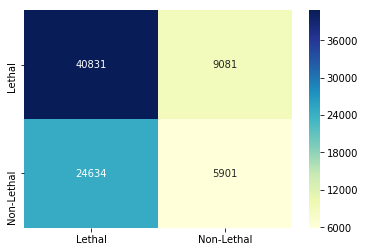

In [28]:
feature_names = ["Hour", "DoW", "NPU Num"]
x_atlpd = atlpd[feature_names]
y_atlpd = atlpd["Lethalness Num"]
target_names = atlpd["Lethalness"].cat.categories

x_train, x_test, y_train, y_test = train_test_split(x_atlpd, y_atlpd, random_state = 0)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(x_train_scaled, y_train)
print "Accuracy of K-NN classifier on training set: {:.2f}".format(knn.score(x_train_scaled, y_train))
print "Accuracy of K-NN classifier on test set: {:.2f}".format(knn.score(x_test_scaled, y_test))

y_predicted = knn.predict(x_test)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_predicted))
plt.figure(figsize = (6, 4))
conf_heat = sns.heatmap(df_cm, annot = True, fmt = "d", cmap = "YlGnBu", xticklabels = target_names, yticklabels = target_names)

print "Accuracy: {:.2f}".format(accuracy_score(y_test, y_predicted))
print "Precision: {:.2f}".format(precision_score(y_test, y_predicted))
print "Recall: {:.2f}".format(recall_score(y_test, y_predicted))
print "F1: {:.2f}".format(f1_score(y_test, y_predicted))

## Logistic Regression for Lethalness

Accuracy of Logistic regression classifier on training set: 0.63
Accuracy of Logistic regression classifier on test set: 0.63
Accuracy: 0.63
Precision: 0.53
Recall: 0.14
F1: 0.22


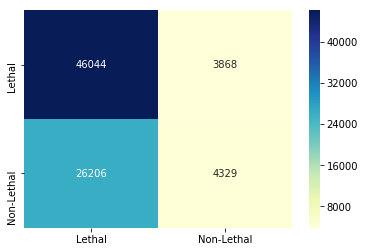

In [29]:
feature_names = ["Hour", "DoW", "NPU Num"]
x_atlpd = atlpd[feature_names]
y_atlpd = atlpd["Lethalness Num"]
target_names = atlpd["Lethalness"].cat.categories

x_train, x_test, y_train, y_test = train_test_split(x_atlpd, y_atlpd, random_state=0)

clf = LogisticRegression(C = 100, solver = "lbfgs", multi_class = "auto")
clf.fit(x_train, y_train)
print "Accuracy of Logistic regression classifier on training set: {:.2f}".format(clf.score(x_train, y_train))
print "Accuracy of Logistic regression classifier on test set: {:.2f}".format(clf.score(x_test, y_test))

y_predicted = clf.predict(x_test)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_predicted))
plt.figure(figsize = (6, 4))
conf_heat = sns.heatmap(df_cm, annot = True, fmt = "d", cmap = "YlGnBu", xticklabels = target_names, yticklabels = target_names)

print "Accuracy: {:.2f}".format(accuracy_score(y_test, y_predicted))
print "Precision: {:.2f}".format(precision_score(y_test, y_predicted))
print "Recall: {:.2f}".format(recall_score(y_test, y_predicted))
print "F1: {:.2f}".format(f1_score(y_test, y_predicted))

## Logistic Regression for Crime

Accuracy of Logistic regression classifier on training set: 0.54
Accuracy of Logistic regression classifier on test set: 0.54
Micro-averaged precision = 0.54 (treat instances equally)
Macro-averaged precision = 0.11 (treat classes equally)
Micro-averaged F1 = 0.54 (treat instances equally)
Macro-averaged F1 = 0.12 (treat classes equally)


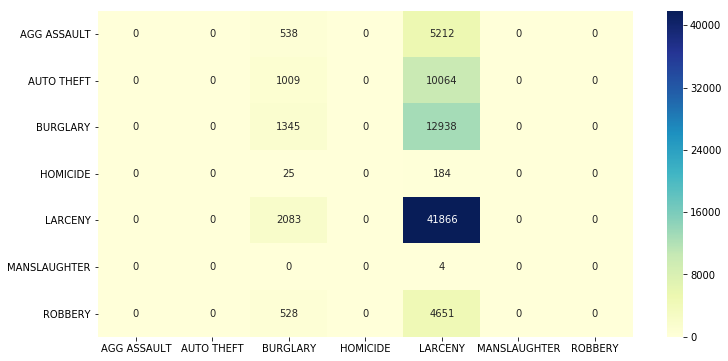

In [38]:
feature_names = ["Hour", "DoW", "NPU Num"]
x_atlpd = atlpd[feature_names]
y_atlpd = atlpd["UCR Code"]
target_names = atlpd["UCR Literal"].cat.categories

x_train, x_test, y_train, y_test = train_test_split(x_atlpd, y_atlpd, random_state=0)

clf = LogisticRegression(C = 20, solver = "lbfgs", multi_class = "auto")
clf.fit(x_train, y_train)
print "Accuracy of Logistic regression classifier on training set: {:.2f}".format(clf.score(x_train, y_train))
print "Accuracy of Logistic regression classifier on test set: {:.2f}".format(clf.score(x_test, y_test))

y_predicted = clf.predict(x_test)

print "Micro-averaged precision = {:.2f} (treat instances equally)".format(precision_score(y_test, y_predicted, average = "micro"))
print "Macro-averaged precision = {:.2f} (treat classes equally)".format(precision_score(y_test, y_predicted, average = "macro"))
print "Micro-averaged F1 = {:.2f} (treat instances equally)".format(f1_score(y_test, y_predicted, average = "micro"))
print "Macro-averaged F1 = {:.2f} (treat classes equally)".format(f1_score(y_test, y_predicted, average = "macro"))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_predicted))
plt.figure(figsize = (12, 6))
conf_heat = sns.heatmap(df_cm, annot = True, fmt = "d", cmap = "YlGnBu", xticklabels = target_names, yticklabels = target_names)

## Decision Tree for Crime

Accuracy of Decision Tree classifier on training set: 0.75
Accuracy of Decision Tree classifier on test set: 0.75
Micro-averaged precision = 0.75 (treat instances equally)
Macro-averaged precision = 0.33 (treat classes equally)
Micro-averaged F1 = 0.75 (treat instances equally)
Macro-averaged F1 = 0.33 (treat classes equally)


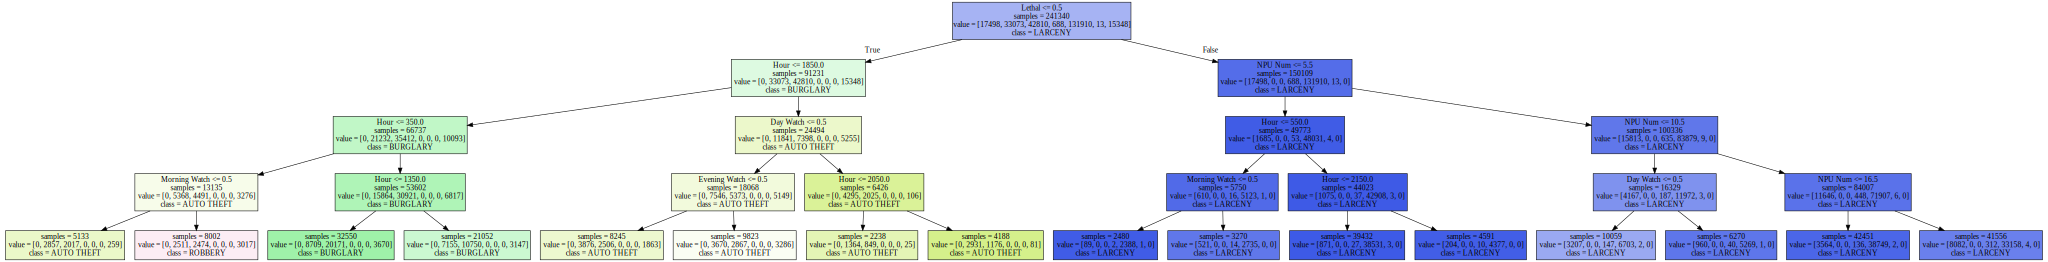

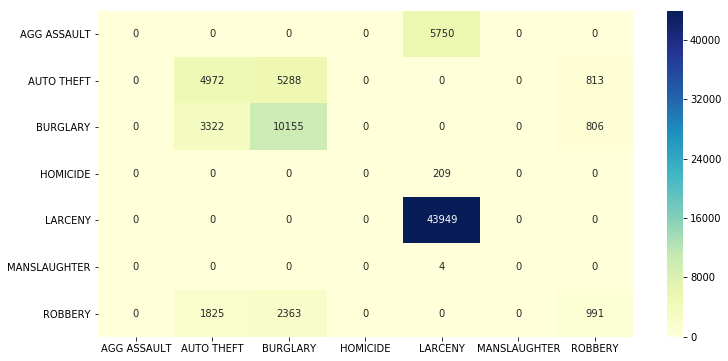

In [37]:
atlpd_extended = atlpd.copy()
atlpd_extended = pd.concat([atlpd_extended, pd.get_dummies(atlpd['Shift Occurrence'])], axis = 1)
atlpd_extended = pd.concat([atlpd_extended, pd.get_dummies(atlpd['Lethalness'])], axis = 1)
atlpd_extended = pd.concat([atlpd_extended, pd.get_dummies(atlpd['Day of Week'])], axis = 1)

feature_names = ["Year", "Month", "Hour", "NPU Num"]
feature_names.extend(pd.get_dummies(atlpd['Shift Occurrence']).columns)
feature_names.extend(pd.get_dummies(atlpd['Lethalness']).columns)
feature_names.extend(pd.get_dummies(atlpd['Day of Week']).columns)
feature_names.remove("Unknown")
x_atlpd = atlpd_extended[feature_names]
y_atlpd = atlpd_extended["UCR Code"]
target_names = atlpd_extended["UCR Literal"].cat.categories

x_train, x_test, y_train, y_test = train_test_split(x_atlpd, y_atlpd, random_state=0)

clf = DecisionTreeClassifier(max_depth = 4).fit(x_train, y_train)
print "Accuracy of Decision Tree classifier on training set: {:.2f}".format(clf.score(x_train, y_train))
print "Accuracy of Decision Tree classifier on test set: {:.2f}".format(clf.score(x_test, y_test))

y_predicted = clf.predict(x_test)

print "Micro-averaged precision = {:.2f} (treat instances equally)".format(precision_score(y_test, y_predicted, average = "micro"))
print "Macro-averaged precision = {:.2f} (treat classes equally)".format(precision_score(y_test, y_predicted, average = "macro"))
print "Micro-averaged F1 = {:.2f} (treat instances equally)".format(f1_score(y_test, y_predicted, average = "micro"))
print "Macro-averaged F1 = {:.2f} (treat classes equally)".format(f1_score(y_test, y_predicted, average = "macro"))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_predicted))
plt.figure(figsize = (12, 6))
conf_heat = sns.heatmap(df_cm, annot = True, fmt = "d", cmap = "YlGnBu", xticklabels = target_names, yticklabels = target_names)

graph = graphviz.Source(export_graphviz(clf, out_file = None, feature_names = feature_names, class_names = target_names, filled = True, impurity = False))
display(SVG(graph.pipe(format = "svg")))

***

# About the data...

## Shape of the DataFrame

In [32]:
atlpd.shape

(321787, 22)

## Types of the columns

In [33]:
atlpd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321787 entries, 0 to 335653
Data columns (total 22 columns):
Report Number        321787 non-null int64
Occur Date           321787 non-null datetime64[ns]
Occur Time           321787 non-null int64
Beat                 321573 non-null float64
Location             321785 non-null object
UCR Literal          321787 non-null category
UCR #                321787 non-null int64
Neighborhood         321787 non-null category
NPU                  321787 non-null category
Latitude             321787 non-null float64
Longitude            321787 non-null float64
Shift Occurrence     321787 non-null object
Year                 321787 non-null int64
Month                321787 non-null int64
Day of Week          321787 non-null category
DoW                  321787 non-null int64
Hour                 321787 non-null int64
NPU Num              321787 non-null int8
Lethalness           321787 non-null category
Lethalness Num       321787 non-null int8